# Overall Flow

There are several parsing steps that just put data into objects
1. Parse the PSM files and get out Organism and Protein objects (currently done with .txt. goal to get .mzIdentML)
2. KEGG mapping
3. Run the Fisher's Exact test on all organisms and all pathways



## Step 1. Parse PSM files
At the end of this, we have a 'Parser.OrganismObjectsDictionary' variable that holds all the proteins and peptides found in an organism. The peptides are in the Protein object inside a dictionary keyed on their sequence

In [1]:
import IdentifyingPeptidesAndProteins
Parser = IdentifyingPeptidesAndProteins.ParserClass()
#parameters
DirectoryOfPSMs = "VanillaSearches.DataPackage1527"
#DirectoryOfPSMs = "test_delme"
FileToOrganismAssociation = "PSMFilesAssociatedByOrganism_new.txt"
Parser.AddFiles(DirectoryOfPSMs, FileToOrganismAssociation)
Parser.SetQvalue(0.0001)
Parser.Main()

I got this path PSMFilesAssociatedByOrganism_new.txt
Associating 205 files from 44 organisms


## Step 2 Parse the KEGG stuff
This leaves us with two things. a ProteinAccessionToKO dictionary and a KOsInAPathway dictionary. With these we should be able to get what we need in terms of which proteins are assigned to which pathways

In [2]:
import ParsingKeggFiles
K_Parser = ParsingKeggFiles.CreatorClass()
#parameters
DirectoryOfGhostKoalaAnnotations = "GhostKoalaAnnotation"
#DirectoryOfGhostKoalaAnnotations = "test_delme2"
PathwayMappingFilePath = "ko_pathway.list"
KoalaFileToOrganismAssociation = "GhostKoalaFilesAssociatedByOrganism.txt"
K_Parser.AddFiles(DirectoryOfGhostKoalaAnnotations, PathwayMappingFilePath)
K_Parser.Main()

## Step 3. Run the Fishers test for enrichment

Go through all the organisms and create the numbers necessary for a fisher's test
<pre>
M = modified proteins
N = not modified proteins
P = proteins in a pathway

x = IN_pathway && Modified = union of M and P
M-x = NOT_IN_pathway && Modified
P-x = IN_pathway && Not_Modified
N-(P-x) = NOT_IN_pathway && Not_Modified
</pre>


Since all these are represented as variabled dependent on X, the only compute that we need to do
is get the intersect of M and P and then len(P) and len(M).

Based on https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html, we can use

<pre>

```python
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact([[x, M-x], [P-x, N-(P-x)]])
```

</pre>


In [25]:
##some nice Methods and Classes that I'll put in it's own box

def intersect(a, b):
    return list(set(a) & set(b))


class PathwayEnrichment:
    #mostly a convenience class for making plots. Could all be done with a set
    #of embedded dictionaries. But no one likes those.
    def __init__(self, PathwayName):
        self.PathwayName = PathwayName
        self.EnrichmentByOrg = {} #key = organism name, value = pvalue
    def GetEnrichmentList(self):
        #return just a simple list of the pvalues, stripped from the association with an organism
        return list(self.EnrichmentByOrg.values())
    def AddValue(self, org, _pvalue):
        self.EnrichmentByOrg[org] = pvalue
    def GetMedian(self):
        #this function looks at the pvalues and finds the median one.
        ListOfPvalues = self.GetEnrichmentList()
        ListOfPvalues.sort() #sort in place
        Length = len(ListOfPvalues)
        HalfWay = int(Length / 2 ) #probably not truly accurate because I don't average the middle if even length, 
        return ListOfPvalues[HalfWay]
        

In [4]:
import scipy.stats as stats

PathwayEnrichmentScores = {} # key = pathway, value = PathwayEnrichmentObject

for OrganismName in Parser.OrganismObjectsDictionary:
    #if not OrganismName == "Paenibacillus polymyxa ATCC842":
    #    #just for sanity in debugging
    #    continue
    OrganismObject = Parser.OrganismObjectsDictionary[OrganismName]
    ModifiedProteinListAsAccessions = OrganismObject.GetModifiedProteinList()
    ModifiedProteinListAsKO = K_Parser.ConvertListOfAccessionsToKOs(ModifiedProteinListAsAccessions)
    num_M = len(ModifiedProteinListAsKO)
    NotModifiedProteinListAsAccessions = OrganismObject.GetNotModifiedProteins()
    NotModifiedProteinListAsKO = K_Parser.ConvertListOfAccessionsToKOs(NotModifiedProteinListAsAccessions)
    num_N = len(NotModifiedProteinListAsKO)
    ObservedProteinsAsAccessions = OrganismObject.Proteins.keys() #get all observed proteins
    ObservedProteinsAsKO = K_Parser.ConvertListOfAccessionsToKOs(ObservedProteinsAsAccessions)
    
    ###now we are looking at the number of proteins both as accessions and as KOs
    #print ("Proteins with Mods: %s total, %s in KO"%(len(ModifiedProteinListAsAccessions), len(ModifiedProteinListAsKO)))
    #print ("Proteins NO Mods: %s total, %s in KO"%(len(NotModifiedProteinListAsAccessions), len(NotModifiedProteinListAsKO)))
    
    #now we test this list of protiens against the KEGG pathways for enrichment using a Fisher's Exact Test
    #Rolling through all the pathways, because there are lots
    for Pathway in K_Parser.KOsInAPathway:
        if not Pathway in PathwayEnrichmentScores:
            PathwayEnrichmentScores[Pathway] = PathwayEnrichment(Pathway)
        
        KOsInPathway = K_Parser.KOsInAPathway[Pathway]
        #it's necessary to limit the list of KO identifiers in a specific pathway
        #to only those that are observed in mass spectrometry data, otherwise
        #we can end up with a negative number in Q4.
        ObservedKOsInPathway = intersect(ObservedProteinsAsKO, KOsInPathway)
        Intersection = intersect(ObservedKOsInPathway, ModifiedProteinListAsKO)
        num_X = len(Intersection)
        num_P = len(ObservedKOsInPathway)
        Q1 = num_X
        Q2 = num_M - num_X
        Q3 = num_P - num_X
        Q4 = num_N-(num_P-num_X)
        #print(num_X, num_M, num_N, num_P)
        oddsratio, pvalue = stats.fisher_exact([[Q1,Q2], [Q3,Q4]], alternative="greater")
        PathwayEnrichmentScores[Pathway].AddValue(OrganismName, pvalue)
        #if pvalue < 0.05:
        #    print(Pathway, pvalue)
#print (PathwayEnrichmentScores)

## Step 4. Making Pictures
Now I'm going through and trying to make images for the various pathways and PTMs

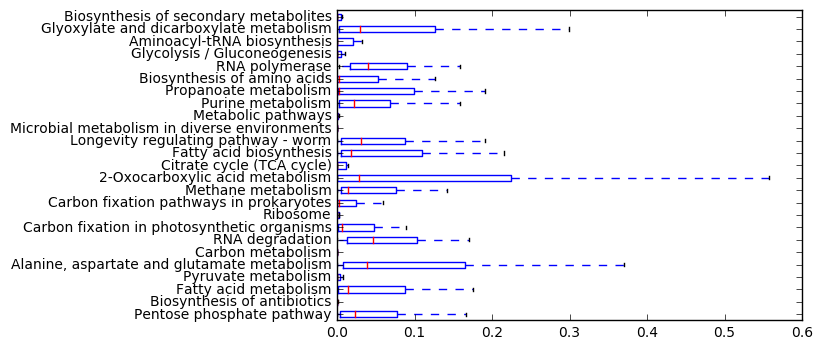

In [24]:
## now that I've computed all the enrichment scores, I will go through and see if any pathways
## are frequently significant across multiple organisms.
import matplotlib.pyplot as plt

ListOfGoodPathways = [] # will serve as labels for the box plot
DataForBoxPlot = [] #going to be a multidimensional array, appended over time

for Pathway in K_Parser.KOsInAPathway: # this loops through the keys, which is the name of the pathways
    MedianValue = PathwayEnrichmentScores[Pathway].GetMedian()
    if MedianValue < 0.05:
        ListOfGoodPathways.append(Pathway)
        #lots of organisms got a good score here. let's print it out
        #print (Pathway, K_Parser.PathwayDescriptions[Pathway])
        #print (PathwayEnrichmentScores[Pathway].EnrichmentByOrg)
#now we've cycled through all the pathways. Let's get working on that data structure for our boxplot

numInclude = 0
PlotLabels = []
for Pathway in ListOfGoodPathways:
    numInclude += 1
    #if numInclude >=4:
    #    continue
    DataForBoxPlot.append( PathwayEnrichmentScores[Pathway].GetEnrichmentList())
    PlotLabels.append(K_Parser.PathwayDescriptions[Pathway])

    
DataForBoxPlot
plt.boxplot(DataForBoxPlot, 0, '', 0, labels=PlotLabels)
plt.show()